# General Setup

In [1]:
# %matplotlib widget

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

category =  "single_family"



In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

# Run

In [5]:
run = 17
qois = ['comp(u,0)', 'comp(u,2)']

In [6]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

In [11]:
stack = [1, 10, 20, 30, 40, 50]

In [12]:
qty_dict = probes.create_qty_dict(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-40000:-1:],
    stack = stack,
)


processing data took 6 seconds
processing data took 6 seconds
processing data took 6 seconds
processing data took 5 seconds


## Spectra

/home/users/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:263: RuntimeWarning: divide by zero encountered in power
  ax.loglog(qty.f, interial_offset*qty.f**(-5/3), label = '-5/3')


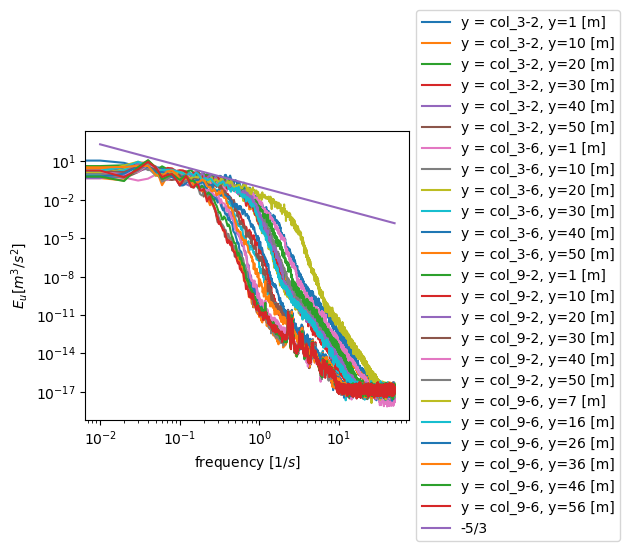

In [13]:
fig, ax = quantities.plot_power_spectra(qty_dict)

## Plot ABL

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>)

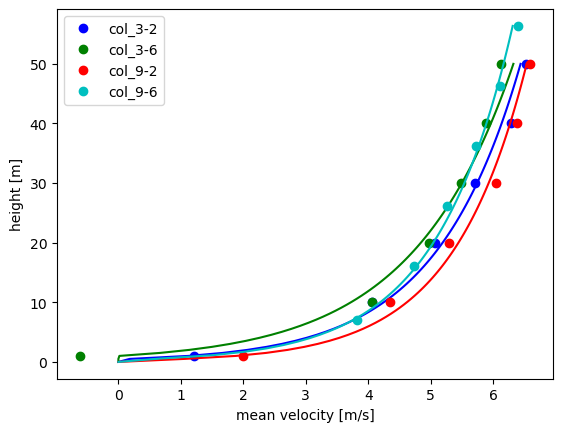

In [15]:
quantities.plot_ABL(qty_dict, fit_disp=True)

## Plot Length Scales

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'Lx'}, xlabel='y [m]', ylabel='L [m]'>,
        <Axes: title={'center': 'Ly'}, xlabel='y [m]'>,
        <Axes: title={'center': 'Lz'}, xlabel='y [m]'>], dtype=object))

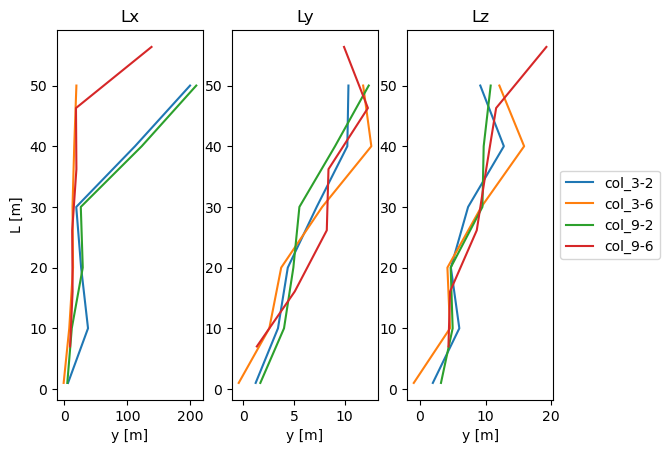

In [16]:
quantities.plot_length_scales(qty_dict)

## Plot Reynolds stresses

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'uu'}, ylabel='y [m]'>,
         <Axes: title={'center': 'vv'}>, <Axes: title={'center': 'ww'}>],
        [<Axes: title={'center': 'uv'}, ylabel='y [m]'>,
         <Axes: title={'center': 'uw'}, xlabel='Reynolds Stress [m^2/s^2]'>,
         <Axes: title={'center': 'vw'}>]], dtype=object))

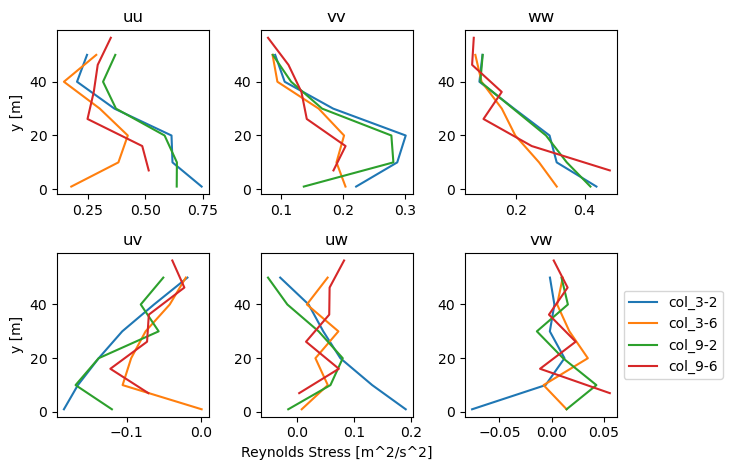

In [17]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='Iu', ylabel='y [m]'>, <Axes: xlabel='Iv'>,
        <Axes: xlabel='Iw'>], dtype=object))

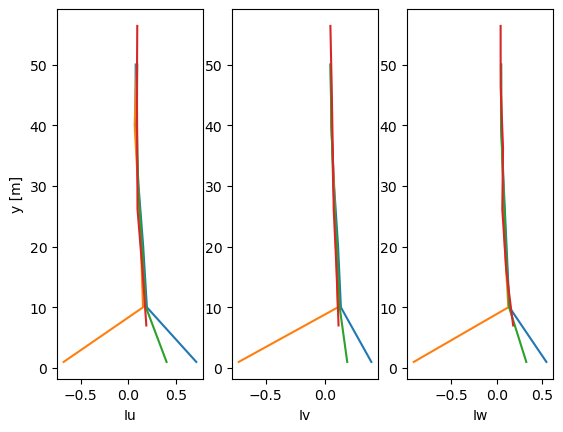

In [18]:
quantities.plot_turbulence_intensities(qty_dict)

## Plot prms

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Prms [Pa]', ylabel='y [m]'>)

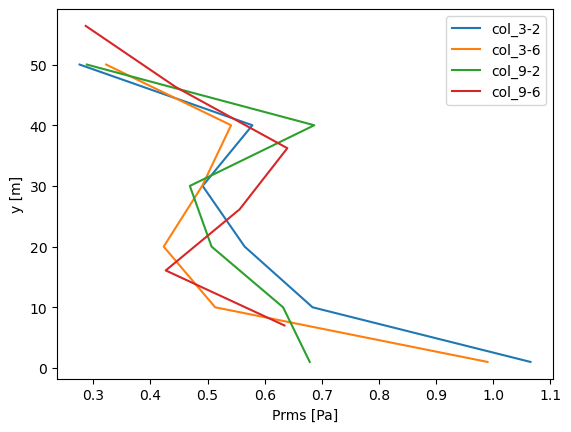

In [19]:
quantities.plot_prms(qty_dict)